# CDDP Tutorial - Cartpole Swing-up MPC

In [1]:
using Plots; gr()
using LinearAlgebra
using BenchmarkTools
using DataInterpolations
using Printf
using Revise
using CDDP

In [2]:
includet("../src/models/cartpole.jl")
model = CartPole()
x_dim, u_dim = model.x_dim, model.u_dim

tf = model.tf
tN = model.tN
dt = model.dt

x_init = model.x_init
x_final = model.x_final
;

In [3]:
function ell_cost(
    x::Vector,
    u::Vector,
    x_ref::Vector{Float64};
)
    
    Q = 1.0e-2*Diagonal(ones(x_dim))
    R = 1.0e-1*Diagonal(ones(u_dim))

    # q = x[1]^2 + 1/2 * x[2]^2 + 50 * (1 + cos(x[3]))^2 +  1/2 * x[4]^2
    return  0.5 * transpose(x - x_ref) * Q * (x - x_ref) + 0.5 * transpose(u) * R * u
    # return q + 0.5 * transpose(u) * R * u
end

function phi_cost(
    x::Vector,
    x_final::Vector{Float64};
)
    Qf = 1.0e+2*Diagonal(ones(x_dim))
    return 0.5 * transpose(x - x_final) * Qf * (x - x_final)
end
;



In [5]:
X_ref = Vector[x_final for t in 1:tN+1]
X_ref =  ConstantInterpolation(X_ref, 0:dt:tf);

prob = iLQRProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    x_dim=x_dim, 
    u_dim=u_dim, 
    ell=ell_cost, 
    ϕ=phi_cost, 
    f=model.f, 
    ∇f=empty, 
    x_init=x_init, 
    x_final=x_final, 
    X_ref=X_ref)
    
sol = solve_ilqr(
    prob, 
    X=nothing, 
    U=nothing, 
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30),
    verbose=false);
    
X_ilqr, U_ilqr  = sol.X, sol.U;

In [112]:
X_sol = [x_init]
xk = x_init
uk = zeros(u_dim)
hN = 100
th = hN * dt

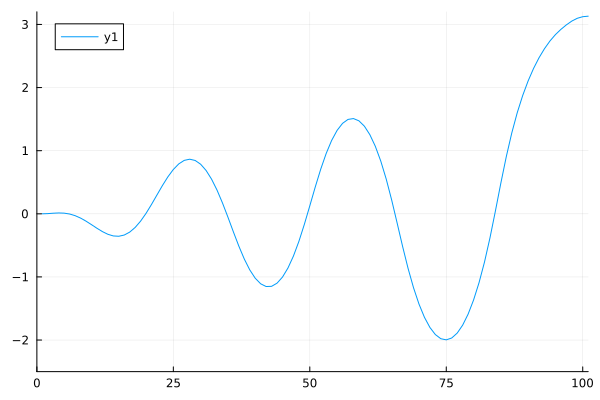

In [9]:

X_arr = Array{Float64}(undef, x_dim, tN+1)

for t in 1:tN+1
    X_arr[:,t] = X_ilqr((t-1)*dt)
end

plot(X_arr[2,:])
plot!(xlims=(0,tN+1), ylims=(-2.5,3.2))
# plot!(X_ilqr[2,:])
# plot(X_ilqr)

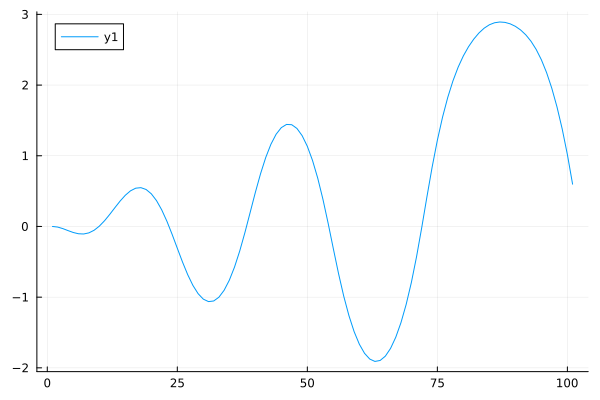

In [72]:
X_arr = Array{Float64}(undef, x_dim, tN+1)
xk = x_init
X_arr[:,1] = xk
for k in 1:tN 
    t = (k-1)*dt
    uk = U(t)
    p = ODEParams(model, uk, isarray=true)
    xk = xk + rk4_step(model.f, xk, p, t, h=dt) * dt
    X_arr[:,k+1] = xk
end
plot(X_arr[2,:])

In [43]:
x_final

4-element Vector{Float64}:
 0.0
 3.141592653589793
 0.0
 0.0

In [57]:

X_sol = [x_init]
xk = x_init
uk = zeros(u_dim)
hN = 10
th = hN * dt

X, U = X_ilqr, U_ilqr

for k in 1:tN+10
    t = (k-1)*dt
    
    # X = simulate_trajectory(model, xk, U, th, dt)

    X_ref = Vector[]
    x_final = X_ilqr((k-1+hN)*dt)
    if k+hN >= tN 
        x_final = [0; pi; 0; 0]
    end
    for kk in 1:hN+1
        tt = (kk - 1) * dt + (k-1) * dt
        x = X_ilqr(tt)
        if k + kk >= tN 
            x = x_final
        end
        push!(X_ref, x)
    end

    X_ref = CubicSpline(X_ref, 0:dt:th)

    prob = DDPProblem(
        model=model, 
        tf=th, 
        tN=hN, 
        dt=dt, 
        x_dim=x_dim, 
        u_dim=u_dim, 
        ell=ell_cost, 
        ϕ=phi_cost, 
        f=model.f, 
        ∇f=empty, 
        x_init=xk, 
        x_final=x_final, 
        X_ref=X_ref)
    
    sol = solve_ddp(
        prob, 
        X=nothing, 
        U=nothing, 
        max_ite=30, 
        tol=1e-8,
        reg_param_x=1e-5, 
        reg_param_x_fact=10.0, 
        reg_param_x_lb=1e-20,
        reg_param_u=1e-3, 
        reg_param_u_fact=10.0,
        reg_param_u_lb=1e-20,
        line_search_steps = 5 .^ LinRange(0, -6, 30),
        verbose=false)

    X = sol.X
    U = sol.U

    uk = U(0.0)
    p = ODEParams(model, uk, isarray=true)
    xk = xk + rk4_step(model.f, xk, p, t, h=dt) * dt

    push!(X_sol, xk)
end
X_sol = hcat(X_sol...);

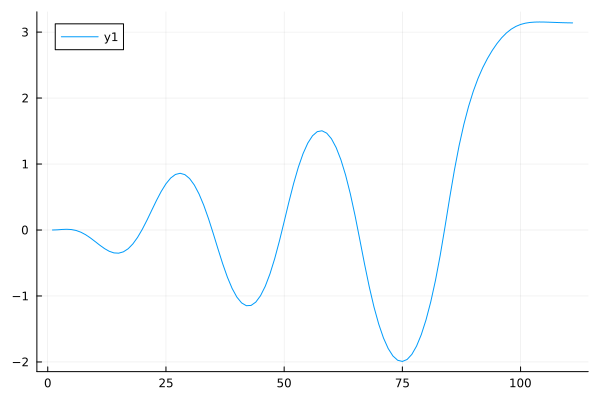

In [59]:
plot(X_sol[2,:])
# plot!(X_arr[2,:])
# plot!(xlims=(0,100), ylims=(-3,3))